Extract PSD feature and also include 7 nets analysis

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap

In [3]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [4]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [5]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    

    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

In [6]:
def get_psd(ts, freq_lmts=[0.008, 0.08]):
    """
    Computes the power spectral density (PSD) of a given time series using Welch's method.
    
    Parameters:
    -----------
    ts : numpy.ndarray
        The time series data. Shape: (n_channels, n_samples).
    freq_lmts : list, optional
        The frequency limits (in Hz) to compute the PSD. Default: [0.008, 0.08].
    
    Returns:
    --------
    fs : numpy.ndarray
        The frequency values (in Hz) of the PSD. Shape: (n_freqs,).
    psds_dB_sm : numpy.ndarray
        The PSD values (in dB) of the time series data after smoothing. Shape: (n_channels, n_freqs).
    """
    lpf = np.array([1, 2, 5, 2, 1]) 
    lpf = lpf/np.sum(lpf)
    ac_time = 485
    fs, psds = welch(ts, fs=ts.shape[1]/ac_time, nperseg=int(ts.shape[1]/2))
    psds_dB = 10*np.log10(psds) # to dB
    psds_dB_sm = []
    for roi_ix in range(ts.shape[0]):
        psds_dB_sm.append(np.convolve(psds_dB[roi_ix],lpf,'same'))
    psds_dB_sm = np.array(psds_dB_sm)
    kpidxs = np.bitwise_and(fs>=freq_lmts[0], fs<=freq_lmts[1])
    return fs[kpidxs], psds_dB_sm[:, kpidxs]
    

## Load data and params

In [21]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321
ac_time = 485

labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}

diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

# Get features

In [8]:
from scipy.signal import welch

lfreq = 0.008
hfreq = 0.08

0.08

In [11]:
all_psds_dB = []
for sub_ix in trange(1, num_sps+1):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts);
    fs, psds_dB = get_psd(ts)
    all_psds_dB.append([fs, psds_dB])
save_pkl(RES_ROOT/"psds.pkl", all_psds_dB)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 174.16it/s]


# Analysis

In [9]:
all_psds_dB = load_pkl(RES_ROOT/"psds.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/psds.pkl


In [11]:
fs = all_psds_dB[0][0];

## In a whole

### Mean power across freq

In [19]:
mpsds_dB = np.array([ psds_dB[1].mean(axis=-1) for psds_dB in all_psds_dB]);

In [32]:
metrics = mpsds_dB.mean(axis=-1)

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print("Mean power")
_get_test_tb(res_df)

Mean power


Test,Pval,Effect size
AD vs HC,0.417,0.121
bvFTD vs HC,0.354,-0.172
CBS vs HC,0.169,-0.298
nfvPPA vs HC,0.091,-0.334
svPPA vs HC,0.190,-0.252
Dementia vs HC,0.302,-0.124
ANOVA,0.083,


In [33]:
metrics = mpsds_dB.std(axis=-1)

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print("Power std")
_get_test_tb(res_df)

Power std


Test,Pval,Effect size
AD vs HC,0.199,0.191
bvFTD vs HC,0.058,0.350
CBS vs HC,0.529,0.137
nfvPPA vs HC,0.619,-0.099
svPPA vs HC,0.718,0.069
Dementia vs HC,0.235,0.143
ANOVA,0.355,


Text(0.5, 0, 'ROI')

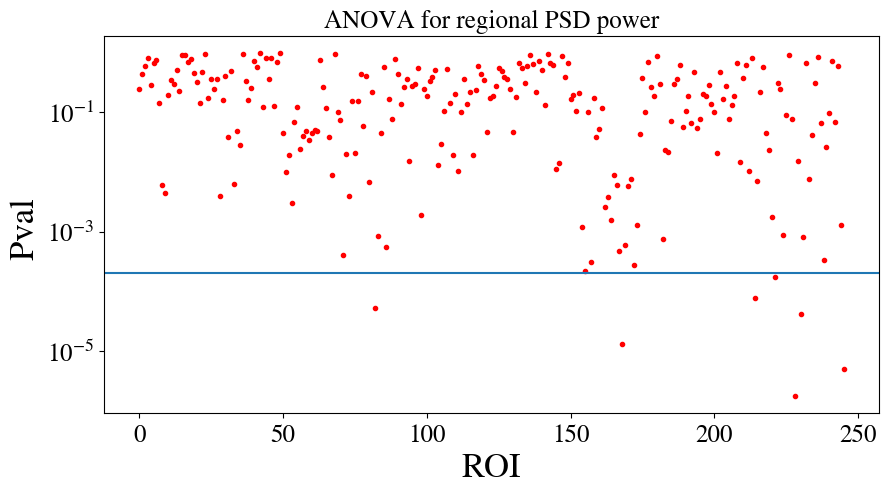

In [34]:
pvals = []
tpvals = []
for roi_ix in range(num_rois):
    metrics = mpsds_dB[:, roi_ix]
    metric_grp = [metrics[diag_labs==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    metric_t = [metrics[diag_labs==grp_ix] for grp_ix in [1, 6]]
    ttest_res = ttest_ind(*metric_t)
    pvals.append(anova_res.pvalue)
    tpvals.append(ttest_res.pvalue)
pvals = np.array(pvals)
tpvals = np.array(tpvals)

plt.plot(pvals, "r.")
plt.yscale("log")
plt.axhline(y=0.05/num_rois)
plt.title("ANOVA for regional PSD power")
plt.ylabel("Pval ")
plt.xlabel("ROI")

Text(0.5, 0, 'ROI')

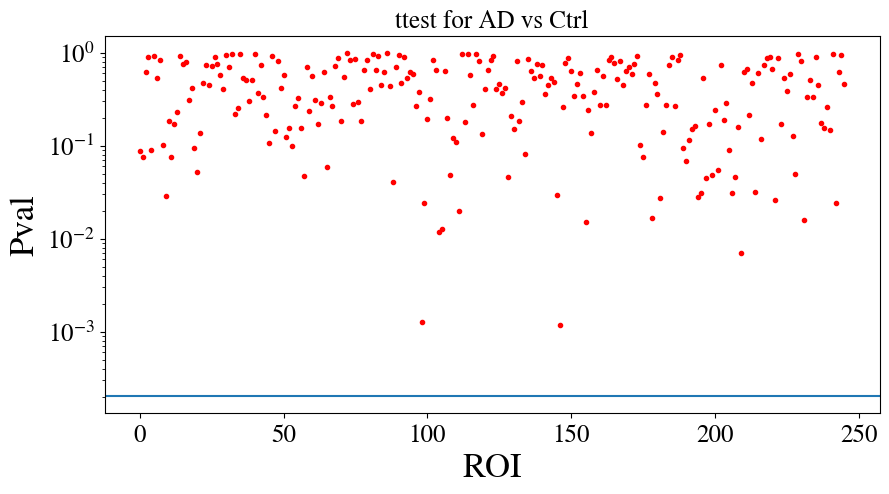

In [35]:
plt.plot(tpvals, "r.")
plt.yscale("log")
plt.axhline(y=0.05/num_rois)
plt.title("ttest for AD vs Ctrl")
plt.ylabel("Pval")
plt.xlabel("ROI")

In [42]:
for net_ix in range(1, 8):
    print(np.median(pvals[yeo_7nets_lab==net_ix]))

0.18332068132735035
0.020373154045538504
0.3271983924086475
0.06051222083877772
0.25084080231743444
0.3482074769453217
0.2738733933625558


In [43]:
for net_ix in range(1, 8):
    print(np.median(tpvals[yeo_7nets_lab==net_ix]))

0.1253382345070683
0.27244231979897604
0.4078748085781653
0.5462621622733151
0.5541364611158385
0.472679227006269
0.46420657537216553


### Mean power across ROI

In [13]:
mpsds_dB_roi = np.array([psds[1].mean(axis=0) for psds in all_psds_dB]);

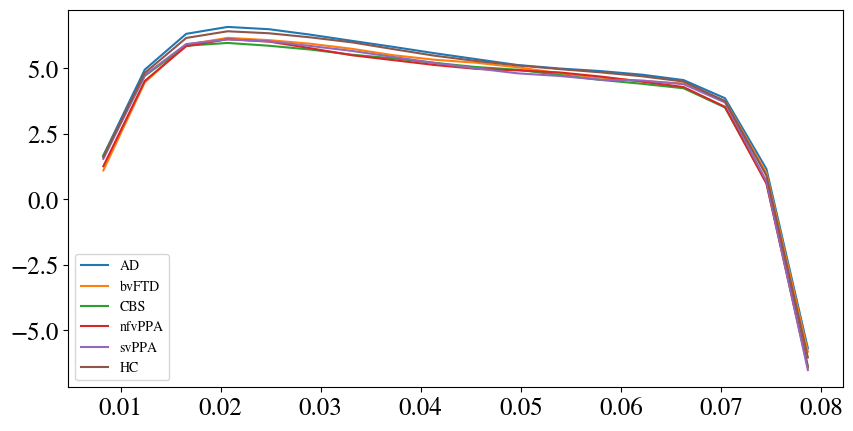

In [14]:
for grp_ix in range(1, 7):
    grp_data = mpsds_dB_roi[diag_labs==grp_ix]
    plt.plot(fs, grp_data.mean(axis=0), label=diag_lab_mapping[grp_ix])
plt.legend(fontsize=10)

In [15]:
pvals = []
tpvals = []
for fs_ix in range(len(fs)):
    metrics = mpsds_dB_roi[:, fs_ix]
    metric_grp = [metrics[diag_labs==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    metric_t = [metrics[diag_labs==grp_ix] for grp_ix in [1, 6]]
    ttest_res = ttest_ind(*metric_t)
    pvals.append(anova_res.pvalue)
    tpvals.append(ttest_res.pvalue)
pvals = np.array(pvals)
tpvals = np.array(tpvals)

Text(0.5, 0, 'Freq')

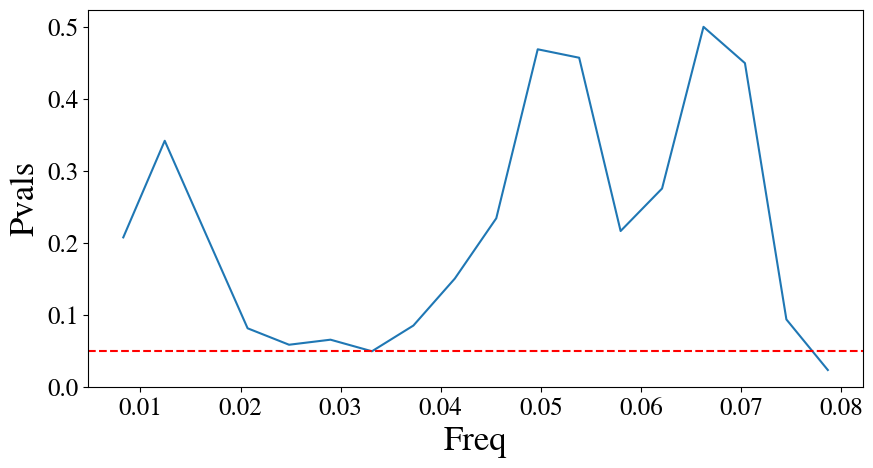

In [16]:
plt.plot(fs, pvals)
plt.axhline(y=0.05, color="red", ls="--")
plt.ylabel("Pvals")
plt.xlabel("Freq")

In [17]:
# based on last plot, let us limit to [0.02, 0.035]
metrics = mpsds_dB_roi[:, np.bitwise_and(fs>=0.02, fs<=0.035)].mean(axis=1)
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
_get_test_tb(res_df)

Test,Pval,Effect size
AD vs HC,0.479,0.105
bvFTD vs HC,0.250,-0.213
CBS vs HC,0.062,-0.403
nfvPPA vs HC,0.078,-0.349
svPPA vs HC,0.161,-0.269
Dementia vs HC,0.207,-0.152
*ANOVA,0.049,


Text(0.5, 0, 'Freq')

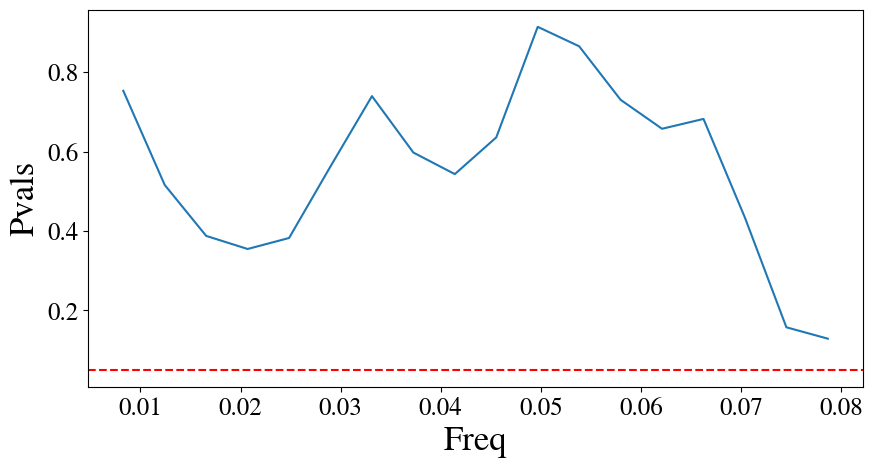

In [16]:
plt.plot(fs, tpvals)
plt.axhline(y=0.05, color="red", ls="--")
plt.ylabel("Pvals")
plt.xlabel("Freq")

## In 7 networks

In [25]:
psds_dB = np.array([foo[1] for foo in all_psds_dB]);


In [31]:
net_ix = 1
for net_ix in range(1, 8):
    sub_mpsds_dB = psds_dB[:, yeo_7nets_lab==net_ix].mean(axis=-1);
    metrics = sub_mpsds_dB.mean(axis=-1)
    
    res_df = pd.DataFrame({
        "metric": metrics, 
        "sex": sex_labs, 
        "diagnosis": diag_labs
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"{yeo_7nets_dict[net_ix]}")
    print(_get_test_tb(res_df))

Visual
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.087 |     0.254   |
|    bvFTD vs HC |  0.641 |     0.087   |
|      CBS vs HC |  0.731 |    -0.075   |
|   nfvPPA vs HC |  0.276 |    -0.216   |
|    svPPA vs HC |  0.493 |    -0.132   |
| Dementia vs HC |  0.705 |     0.046   |
|          ANOVA |  0.136 |             |
+----------------+--------+-------------+
Somatomotor
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.295 |     0.156   |
|    bvFTD vs HC |  0.156 |    -0.262   |
|     *CBS vs HC |  0.019 |    -0.503   |
|   nfvPPA vs HC |  0.060 |    -0.372   |
|    svPPA vs HC |  0.189 |    -0.252   |
| Dementia vs HC |  0.179 |    -0.162   |
|         *ANOVA |  0.004 |             |
+----------------+--------+-------------+
Dorsal_Attention
+----------------+--------+-------------